In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time

from pyDOE import lhs

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [37]:
class Model(nn.Module):
    def __init__(self,
                in_size = 3, 
                neurons_layer=[10, 10],
                out_size = 1
                ):
        """
        Initializing the PINN
        """
        nn.Module.__init__(self)

        self.layers = nn.ModuleList()

        # first layer
        self.layers.append(nn.Linear(in_features=in_size, out_features=neurons_layer[0])) 

        # hidden layers
        for n_in, n_out in zip(neurons_layer[:-1], neurons_layer[1:]):
            self.layers.append(nn.Linear(in_features=n_in, out_features=n_out))

        # output layer
        self.out  = nn.Linear(in_features=neurons_layer[-1], out_features=out_size)
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward Pass
        """
        for linear in self.layers:
            x = self.tanh(linear(x))
        x = self.out(x)
        return x

In [38]:
class PINN_loss(nn.Module):
    def __init__(self):
        """
        Inputs :
            net_u : 
            net_f
            device : self explenatory, cuda if possible 
        """
        nn.Module.__init__(self)

    def forward(self,u,u_pred,f_pred):
        loss_u = torch.mean((u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)

        loss = loss_u + loss_f
        return loss, loss_u, loss_f

In [39]:
class Net_U(nn.Module):
    def __init__(self,dnn):

        nn.Module.__init__(self)

        self.dnn = dnn

    def forward(self, x, y, t):
        u = self.dnn(torch.cat([x, y, t], dim=1))
        return u

In [40]:
class Net_F(nn.Module):
    def __init__(self, net_u, nu):
        """
        Compute the residuals

        Inputs :
            net_u : 
            nu : 
            device : self explenatory, cuda if possible 
        """
        nn.Module.__init__(self)
        self.net_u = net_u
        self.nu = nu

    def forward(self, x, y, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, y, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_xx + u_yy - 1/self.nu * u_tt
        return f

In [41]:
import pandas as pd

import h5py

In [42]:
path = "NoCracK/Simple_Homogeneous/Event0000/output.h5"

hf = h5py.File(path, 'r')

In [43]:
loc = hf['coordinates_ACOUSTIC'][:].reshape(hf['coordinates_ACOUSTIC'][:].shape[0]*hf['coordinates_ACOUSTIC'][:].shape[1],2)

df = pd.DataFrame(columns={'X','Y'})
df['X'] = loc[:,0]
df['Y'] = loc[:,1]
df['X'] = np.round(df['X'],5)
df['Y'] = np.round(df['Y'],5)

t_s_start = 50
t_s_end = 150

df['PHI_start'] = hf['volume']['phi'][t_s_start,:,:,:25].reshape(2500*25)
df['PHI_end'] = hf['volume']['phi'][t_s_end,:,:,:25].reshape(2500*25)

df_clean = df.loc[ \
    (df['X'].isin(np.sort(df['X'].unique())[::2])) &\
    (df['Y'].isin(np.sort(df['Y'].unique())[::2]))\
    ] # Reduce the mesh by two

df_start = df.pivot_table(values='PHI_start',index='Y',columns='X').sort_index(axis=0,ascending=False)
df_end = df.pivot_table(values='PHI_end',index='Y',columns='X').sort_index(axis=0,ascending=False)
df_clean_start = df_clean.pivot_table(values='PHI_start',index='Y',columns='X').sort_index(axis=0,ascending=False)
df_clean_end = df_clean.pivot_table(values='PHI_end',index='Y',columns='X').sort_index(axis=0,ascending=False)

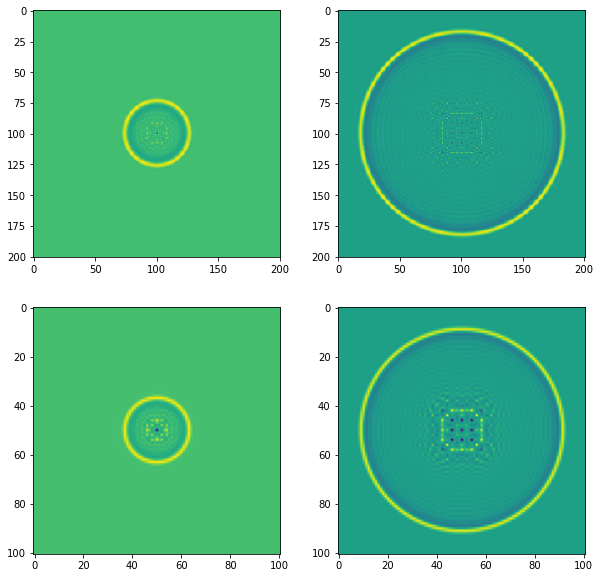

In [44]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(df_start.values)
ax[0,1].imshow(df_end.values)
ax[1,0].imshow(df_clean_start.values)
ax[1,1].imshow(df_clean_end.values)

In [45]:
time = ((0.0005/10000) * 10) * 1 # Final time of the simulation / number of timesteps * wavefield saving frequency * selected timestep 

In [54]:
df_u_train = pd.DataFrame()

for i in range(50,151,2):
    df = pd.DataFrame(columns={'X','Y'})
    df['X'] = loc[:,0]
    df['Y'] = loc[:,1]
    df['X'] = np.round(df['X'],5)
    df['Y'] = np.round(df['Y'],5)

    df['T'] =  np.round(((0.0005/10000) * 10) * i, 10)

    df['PHI'] = hf['volume']['phi'][i,:,:,:25].reshape(2500*25)

    df_clean = df.loc[ \
    (df['X'].isin(np.sort(df['X'].unique())[::2])) &\
    (df['Y'].isin(np.sort(df['Y'].unique())[::2]))\
    ] # Reduce the mesh by two

    df_clean = df_clean.drop_duplicates(subset=['X','Y'])

    df_u_train = pd.concat((df_u_train,df_clean),axis=0)

df_u_train.reset_index(drop=True, inplace=True)

In [55]:
# Watch out with the duplicates

#plt.imshow(df_clean.drop_duplicates(subset=['X','Y']).reset_index().pivot_table(values='PHI',index='Y',columns='X').sort_index(axis=0,ascending=False).values)

#plt.imshow(df_clean.groupby(by=['X','Y']).mean().reset_index().pivot_table(values='PHI',index='Y',columns='X').sort_index(axis=0,ascending=False).values)

In [56]:
df_ic_train = df_u_train.iloc[:df_clean.shape[0],:]

In [71]:
N_f = 10000
N_u = 5000

# Train data for initial condition
idx = np.random.choice(df_ic_train.shape[0], N_u, replace=False)

X_u_train = df_ic_train.loc[idx,['X','Y','T']].values
u_train = df_ic_train.loc[idx,['PHI']].values

# Train data for residuals

X_f_train = lhs(3, N_f)
X_f_train[:,:2] = X_f_train[:,:2]* 0.25
X_f_train[:,2] = np.round(((0.0005/10000) * 10) * 50, 10) + (np.round(((0.0005/10000) * 10) * 150, 10) - np.round(((0.0005/10000) * 10) * 50, 10)) * X_f_train[:,2]

#idx = np.random.choice(df_u_train.shape[0], N_f, replace=False)

#X_f_train = df_u_train.loc[idx,['X','Y','T']].values
#f_train = df_u_train.loc[idx,['PHI']].values

In [72]:
X_f_train = np.vstack((X_u_train,X_f_train)) 

(array([3.000e+00, 1.000e+01, 8.700e+01, 8.990e+02, 8.639e+03, 1.170e+02,
        8.500e+01, 1.120e+02, 3.800e+01, 1.000e+01]),
 array([-36.60833  , -27.976274 , -19.34422  , -10.712164 ,  -2.0801086,
          6.5519466,  15.184002 ,  23.816057 ,  32.448112 ,  41.08017  ,
         49.712223 ], dtype=float32),
 <BarContainer object of 10 artists>)

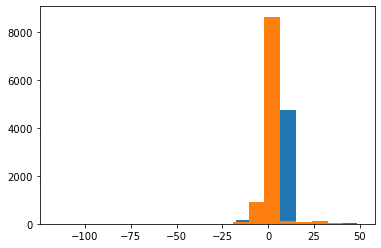

In [74]:
plt.hist(u_train)
plt.hist(f_train)

## Training

In [76]:
dnn = Model()
dnn = dnn.to(device)

optimizer = torch.optim.Adam(dnn.parameters(), lr=1e1)

net_u = Net_U(dnn=dnn)
net_f = Net_F(net_u=net_u,nu=1400)

pinn_loss = PINN_loss()

# data
x_u = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
y_u = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
t_u = torch.tensor(X_u_train[:, 2:3], requires_grad=True).float().to(device)

x_f = torch.tensor(X_f_train[:, 0:1], requires_grad=True).float().to(device)
y_f = torch.tensor(X_f_train[:, 1:2], requires_grad=True).float().to(device)
t_f = torch.tensor(X_f_train[:, 2:3], requires_grad=True).float().to(device)

u = torch.tensor(u_train).float().to(device)

epoch = 1000

dnn.train()
for i in range(epoch):

    optimizer.zero_grad()

    preds_u = net_u(x_u, y_u, t_u)
    preds_f = net_f(x_f, y_f, t_f)

    loss, loss_u, loss_f = pinn_loss(u,preds_u,preds_f)

    loss.backward()

    optimizer.step()

    if i % 10 == 0:
        print('Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (i,loss, loss_u, loss_f))

Iter 0, Loss: 2.75142e+01, Loss_u: 2.75142e+01, Loss_f: 8.53323e-04
Iter 10, Loss: 1.63819e+02, Loss_u: 1.63819e+02, Loss_f: 0.00000e+00
Iter 20, Loss: 2.44461e+02, Loss_u: 2.44461e+02, Loss_f: 0.00000e+00
Iter 30, Loss: 5.30254e+01, Loss_u: 5.30254e+01, Loss_f: 0.00000e+00
Iter 40, Loss: 6.62776e+01, Loss_u: 6.62776e+01, Loss_f: 0.00000e+00
Iter 50, Loss: 3.42922e+01, Loss_u: 3.42922e+01, Loss_f: 0.00000e+00
Iter 60, Loss: 2.85546e+01, Loss_u: 2.85546e+01, Loss_f: 0.00000e+00
Iter 70, Loss: 2.80276e+01, Loss_u: 2.80276e+01, Loss_f: 0.00000e+00
Iter 80, Loss: 2.78824e+01, Loss_u: 2.78824e+01, Loss_f: 0.00000e+00
Iter 90, Loss: 2.74224e+01, Loss_u: 2.74224e+01, Loss_f: 0.00000e+00
Iter 100, Loss: 2.72458e+01, Loss_u: 2.72458e+01, Loss_f: 0.00000e+00
Iter 110, Loss: 2.72717e+01, Loss_u: 2.72717e+01, Loss_f: 0.00000e+00
Iter 120, Loss: 2.72430e+01, Loss_u: 2.72430e+01, Loss_f: 0.00000e+00
Iter 130, Loss: 2.72405e+01, Loss_u: 2.72405e+01, Loss_f: 0.00000e+00
Iter 140, Loss: 2.72411e+01, Lo

In [20]:
X_star = df_u_train[['X','Y','T']].values

u_star =  df_u_train[['PHI']].values

In [21]:
x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
y = torch.tensor(X_star[:, 1:2], requires_grad=True).float()
t = torch.tensor(X_star[:, 2:3], requires_grad=True).float()

dnn.eval().to(torch.device('cpu'))

u_preds = net_u(x, y, t)

In [22]:
u_preds = u_preds.detach().numpy()

In [23]:
error_u = np.linalg.norm(u_star-u_preds,2)/np.linalg.norm(u_star,2)

In [24]:
print(error_u)

0.99962157


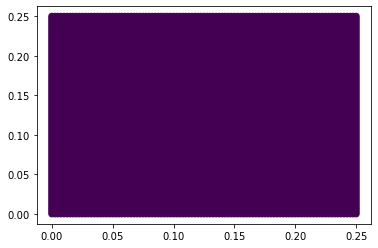

In [27]:
plt.scatter(X_star[:df_clean.shape[0]][:,0],X_star[:df_clean.shape[0]][:,1],c=u_preds[0*df_clean.shape[0]:1*df_clean.shape[0]])

In [25]:
from sklearn.metrics import r2_score 

In [26]:
R_square = r2_score(u_preds, u_star)

In [29]:
R_square

0.0

In [53]:
(lhs(3, N_f)*0.25)

array([[0.22750268, 0.12050205, 0.07960803],
       [0.16444527, 0.05345562, 0.00441272],
       [0.08024476, 0.23962443, 0.14280954],
       ...,
       [0.01309572, 0.0708918 , 0.21087662],
       [0.18099491, 0.18538995, 0.13784097],
       [0.11535864, 0.08285572, 0.0653088 ]])